This is the code file (jupyter notebook) for the final project in Statistical Theory spring semester of 2021, given in by Yisrael Haber and Hadar Kaner. 

In order to use this run the code blocks, one after the other, and look at the results. In addition we have submitted a PDF or .html file version of this where you can view
the results in an easy and convenient format to read (notice that what we run is "probabilistic" and so the PDF will probably present different results from
when you run the code, the PDF only presents results from a previous running of the code.)

The first part of the code concerns a numerical plot that is presented in the last part of the 3rd problem and it's meaning.

From there on the code is the solution to the 5 different parts of the 4th problem - 

* **4.(1): Sampling and visualizing the pareto distributions (2 different methods).** - 

    * First method is a "by hand" sampling - sampling the uniform distribution, and inverting it using the CDF.

    * Second method is using a numpy built-in function, we use this during the rest of the code sampling for improved speed when the number of samples is very large, but we can use the first method too.

* **4.(2): Code for calculating the likelihood of a single sampling, and using that to calculate the log-likelihood**
  **of a sampling. There is also a calculation of the log-likelihood of a sampling from the previous problem.**


* **4.(3): Calculation of the MLE of a sampling (2 different methods)** - 
    
    * First method presents and uses the gradient descent method (numerical solution), where we minimize the negative-log-likelihood.

    * Second method is a solution using derivation of the log-likelihood formula. (analytical solution)

  **In Addition A Comparison Of Both methods, And A Plot Of The Log-Likelihood Function In Order To Verify That Both Find The MLE.** 

* **4.(4): Generating Confidence Intervals (2 different methods)** - 

    * First method is using the MLE calculation from the previous part as asked.

    * Second method is using the pivot method to get the intervals, this also contains visualizations and comparisons (between a naive and a smart implementation).

* **4.(5): Comparison Of Means Of Samplings For "sensitive" $\alpha$ Values**


# Explanation For The End Of 3.(7)
First we will just put here the explanation for the plot that appears in the last part of the third question. The fact that the function (appears below) will be less than 1 serves as a proof that $\hat{T}$ is better than z. This is because we have seen that both are  unbiased, and the coefficient describes the relation between the variance. A coefficient less than 1 implies that the variance of $\hat{T}$ is less than that of z. This means it is a better estimate. Assymptotically though they seem like they would be more or less equivalent (according to the following plot). This function is
$$2 \left(\frac{n\Gamma(n)^4}{\Gamma(n-\frac{1}{2})^2\Gamma(n+\frac{1}{2})^2} - (n-1)\right)$$
And so the plot is - 

100%|██████████| 58/58 [00:00<00:00, 939264.99it/s]


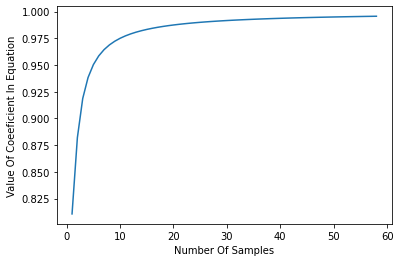

In [2]:
from math import gamma
import matplotlib.pyplot as plt
from tqdm import tqdm


# For every value this calculates the above function, in particular we will consider only interger values.
def function_to_plot(num):

    numerator = num * (gamma(num) ** 4)
    denominator = (gamma(num-0.5) ** 2)*(gamma(num+0.5) ** 2)

    return 2*((numerator)/(denominator)-num +1)

# Sampling the values for all the numbers between 1 and 50
numbers = list(range(59))[1:]
func_vals = [function_to_plot(val) for val in tqdm(numbers)]

# Plots the above values
plt.xlabel("Number Of Samples")
plt.ylabel("Value Of Coeeficient In Equation")
plt.plot(numbers, func_vals)
plt.show()

# 4.(1): Sampling and visualizing the pareto distributions (2 different methods)
 There are 2 ways to sample the Pareto distribution - one is doing this "by hand" and one that is utilizing more internal functions. We will present the method of doing it by hand, but we will use the more built-in one during the project for speed's sake.  

## By Hand Method: 

Notice that that if we denote the CDF of the pareto distribution by F then 
$$F(x) = \left(\int_{-\infty}^x f_X(t)dt \right)\cdot 1_{\{x\geq x_m\}}= \left(\int_{x_m}^x \frac{\alpha\cdot x_m^{\alpha}}{t^{\alpha+1}}dt\right)\cdot 1_{\{x\geq x_m\}} = -\left[\frac{\alpha\cdot x_m^{\alpha}}{\alpha\cdot t^{\alpha}}\right]_{x_m}^x \cdot 1_{\{x\geq x_m\}}= \begin{cases}1-\left(\frac{x}{x_m}\right)^{\alpha}, & x\geq x_m \\ 0, & \text{Otherwise}\end{cases}$$
    
And as we have seen in the lecture $F(X)\sim \mathcal{U}(0,1)$, and so we can get that as long as we can sample a uniform distribution U then we can also sample a pareto distribution with $\frac{x_m}{^{\alpha}\sqrt{(1-U)}}$. And so if we can sample uniform distributions we can also do so for pareto, this implies the following method - 

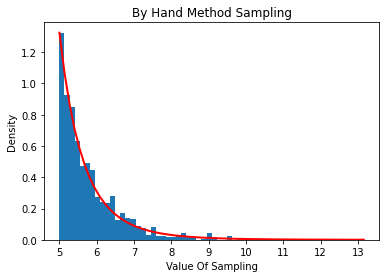

In [3]:
from scipy.stats import uniform 


# Returns a sampling of the uniform distribution on the interval (0,1).
def uniform_dist(number_of_samples):
    return uniform.rvs(0, 1, number_of_samples)


# Returns the inverse of the Pareto distributionat a certain value. 
def pareto_inverse_cdf(val, xm, alpha):
    return xm/((1-val)**(1/alpha))


# Executes the sampling as described above using the previous functions.
def sample_pareto(xm, alpha, number_of_samples):
    return pareto_inverse_cdf(uniform_dist(number_of_samples), xm, alpha)


# Initianlizing the values.
xm, alpha, sample_number = 5, 7, 10**3
sample_by_hand = sample_pareto(xm, alpha, sample_number)

# Sampling, creating the histograms and creating the correct density function.
count, bins, _ = plt.hist(sample_by_hand, 60, density=True)
fit = alpha*xm**alpha / bins**(alpha+1)

# Plotting the sampling and the density function.
plt.plot(bins, max(count)*fit/max(fit), linewidth=2, color='r')
plt.title("By Hand Method Sampling")
plt.xlabel("Value Of Sampling")
plt.ylabel("Density")
plt.show()


Where the red line is the real density function. We can see that histograms are very close. 

## Numpy Built-In Method
In the document we present a comparison of both visualizations of sampling, it is done in the exact way above. We will not leave it here in the code because it isn't necessary. The actual sampling using this method can be done with the following line of code - 

In [4]:
import numpy as np

samples_np = (np.random.pareto(alpha, sample_number) + 1) * xm

# 4.(2) - Likelihood And Log-Likelihood Calculation 
Now we are interested in calculating the likelihoods, and log likelihoods. First notice that for a single sampling the likelihood is just the density function and so for the pareto distribution that would look like this - 

In [5]:
def single_sample_likelhood(sample_value, xm, alpha):
    
    if sample_value < xm:
        return 0
    
    return (alpha * (5 ** alpha))/(sample_value ** (alpha + 1))

Now for the log-likelihood notice first that under the assumpton of independence of the sampling we have that the likelihood is 

$$L\left(\alpha; \overrightarrow{x}\right)=\prod_{i=1}^n f_X(x_i)$$

And so the log-likelihood is

$$l\left(\alpha; \overrightarrow{x}\right)=\log\left(\prod_{i=1}^n f_X(x_i)\right) = \sum_{i=1}^n \log(f_X(x_i))$$

(The reason we apply log individually and sum instead of multiply and then apply log is because otherwise the product value can get too large to apply the likelihood to, which can lead to errors later on.)

And so the code for total log-likelihood would be

In [6]:
def general_log_likelihood(sample_values, xm, alpha):
    
    likelihoods = [np.log(single_sample_likelhood(smp, xm, alpha)) for smp in sample_values]
    
    return np.sum(likelihoods)

And so the following calculates the general log-likelihood of our previous sampling - 

In [7]:
print(general_log_likelihood(samples_np, xm=5, alpha=7))

-781.5728376924166


# 4.(3): MLE Calculation Using 2 Methods, Comparison Of These Methods And Corresponding Visualization.


## Gradient Descent Method
Finding  the  maximal  log-likelihood  is  equivalent  to  finding  the  minimal  negative  log-likelihood. To solve this we will use Gradient Descent ([Gradient Descent Wikipedia Article](https://en.wikipedia.org/wiki/Gradient_descent)). 

To employ this method we will obviously need to calculate gradients, in this case just derivatives. In this example this means we have to find the numerical derivative at any possible point (we assume continuity and differentiablity, which is very evident from the function we are trying to minimize).  This can be found in the following function -

In [9]:
def numeric_derivative(sample_vals, xm, val, theta):

    left_val = - general_log_likelihood(sample_vals, xm, val - theta)
    right_val = - general_log_likelihood(sample_vals, xm, val + theta)
    
    return (right_val - left_val)/(2*theta)

This is based on the following approximation for the derivative - 
$$\text{If f is differentiable then }\forall\theta>0: f'(x)\approx \frac{f(x+\theta)-f(x-\theta)}{2\theta}$$

All together the gradient descent method can be implemented in the following way - 

In [10]:
def gradient_descent(sample_vals, xm, start_point, theta, epsilon, learning_rate):

    # Calculates for the first time where the next point is.
    derivative = numeric_derivative(sample_vals, xm, start_point, theta)
    next_point = start_point - derivative * learning_rate

    # The condition is that we should continue unless we move less then a given threshold, in that case we should be near the minimum.
    while np.abs(next_point - start_point) > epsilon:

        # Just operates the next step
        derivative = numeric_derivative(sample_vals, xm, next_point, theta)
        start_point = next_point
        next_point = next_point - derivative * learning_rate

    return start_point

Where the start point is the first point/guess we choose, theta is the accuracy we use for the numeric derivatives we will use in the process.  We then use epsilon to denote our threshold for when we stop the process - if we move by less than epsilon then we should be close enough to the minimum.  The variable learning_rate denotes the learning rate $\gamma$ we will use in the process of the gradient descent.  What the function returns is where we think the maximal log likelihood, and to calculate the log-likelihood of this $\alpha$, we can just apply the general log-likelihood function on this value. Now we can test this method, to try to confirm that this method works well. We can both check our method converges, and that when it converges that it converges to the right place. First to see where it is supposed to converge to we will calculate this analytically. 

## Analytical Method

Notice that the negative log-likelihood function is of the following form 

$$l\left(\alpha;\overrightarrow{x}\right) = - n\left(\log\alpha+n\log x_m\right) + (\alpha+1)\sum_{i=1}^n\log x_i$$

Where $l$ is the negative log likelihood. Now we want to find the alpha that minimizes this function. And so we will find when the derivative gives 0 - 

\begin{align*}
    \frac{d}{d\alpha} l =  - n\cdot\frac{1}{\alpha} - n\log x_m + \sum_{i=1}^n \log x_i &= 0 \\ \frac{n}{\alpha} &= n\log x_m - \sum_{i=1}^n \log x_i \\ \alpha &= \frac{n}{n\log x_m - \sum_{i=1}^n \log x_i}
\end{align*}

Now notice that
$$\frac{d^2}{d\alpha^2} l = -n\cdot \frac{-1}{\alpha^2} = \frac{n}{\alpha^2}>0$$

And so this is in fact a minimum point. This gives us the function of what the real minimizing $\alpha$ should be according to the sample (MLE) in the following function

In [11]:
def real_mle_alpha(sample_vals, xm, num_of_samples):

    sum_of_logs = np.sum(np.log(sample_vals)) 

    return num_of_samples/(sum_of_logs - num_of_samples*np.log(xm))

## Comparison And Visualization Of The Methods, And Plot Of Log-Likelihood

Now we want to see how close our prediction with the gradient descent method is to the real value, we will use our previous example. For this we will run the following code. This code uses both the gradient descent method and the analytical method to find the MLE. It then plots the log-likelihood, and shows where the gradient descent alpha is so we can see how close it is to where it should be.  

The value we get from the gradient descent is: 7.154839860378388
The value of the real MLE is: 7.15534658109489


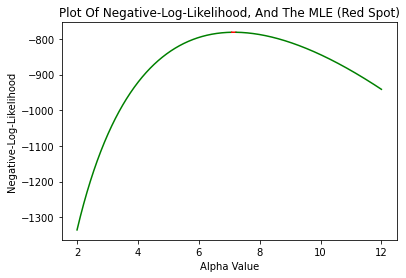

0

In [12]:
def create_vals_for_plot_of_log_likelihood(sample, xm, min_alpha, end_alpha, step_num, real_alpha_val):
    
    # Generates a bunch of values to use for the plot, where we also locate a value that is close enough to the 
    # gradient descent method alpha. 
    x_vals = np.linspace(min_alpha, end_alpha, step_num)
    real_alpha_val_ind = np.argmax(x_vals>real_alpha_val)
    y_vals = [general_log_likelihood(sample, xm, alpha) for alpha in x_vals]

    # Generate the plot almost right before the gradient descent MLE alpha.
    plt.plot(x_vals[:real_alpha_val_ind-7], y_vals[:real_alpha_val_ind-7],color='green')

    # Highlight a very small interval near the gradient descent MLE alpha.
    plt.plot(x_vals[real_alpha_val_ind-7:real_alpha_val_ind+7], y_vals[real_alpha_val_ind-7:real_alpha_val_ind+7], color='red')

    # Generate the rest of the plot.
    plt.plot(x_vals[real_alpha_val_ind+7:], y_vals[real_alpha_val_ind+7:], color='green')

    plt.title("Plot Of Negative-Log-Likelihood, And The MLE (Red Spot)")
    plt.xlabel("Alpha Value")
    plt.ylabel("Negative-Log-Likelihood")
    plt.show()

    return 0


alpha_val = gradient_descent(samples_np, xm, 5, 10**(-5), 10**(-5), 10**(-3))
print(f"The value we get from the gradient descent is: {alpha_val}")
print(f"The value of the real MLE is: {real_mle_alpha(samples_np, xm, sample_number)}")
create_vals_for_plot_of_log_likelihood(samples_np, xm, 2, 12, 10**3, alpha_val)

And as can be seen the red spot is very much at the top of the curve - and so the GD method works very well. Now we can consider the accuracy of the gradient descent method that we get from ourcode. And as we can see the analyitcal and gradient descent values are very very close implying the accuracy of the method. 

# 4.(4): Confidence Intervals Calculation (2 different methods)
We will present 2 methods - one based on using an MLE based approach using the previous part, the other based on the pivot method. First we will present the MLE one - 

## MLE Method:


We know that the MLE method gives us a good estimate for $\alpha$, and so if we sample enough MLE's we can get a confidence interval by taking an interval that contains a specific ratio of the MLE's to get what we want. This can be done with the following code

In [13]:
def numerical_interval(smp_size, alpha, xm, num_of_mles, sig):

    mles = []

    # Generating samples and appending their MLE's to the mles list.
    for i in range(num_of_mles):
        sample = (np.random.pareto(alpha, smp_size) + 1) * xm
        mles.append(real_mle_alpha(sample, xm, smp_size))

    # Sorts the mles in order to find a confidene interval.
    sorted_mle = sorted(mles)
    lower = sorted_mle[int(((1 - sig)/2)* num_of_mles)]
    upper = sorted_mle[int((1 - (1 - sig)/2)* num_of_mles)]

    # Returns the 2 values at the ends of the confidence intervals.
    return lower, upper


def create_one_hundred_intervals_numerically(smp_size, alpha, xm, num_of_mles, sig):
    
    # Creates the list of the left sides of the intervals and the right side of the intervals.
    list_of_intervals = []

    # Does this one hundred times and appends to the lists of the values.
    for i in tqdm(range(100)):

        # Calculates the intervals and adds the values.
        interval = numerical_interval(smp_size, alpha, xm, num_of_mles, sig)
        list_of_intervals.append((interval[0], interval[1]))

    return list_of_intervals

Of course we can just change the significance (changing the percent value). Now we would like to to test out the method. It would make sense to check out the length of the interval (we will look at the mean and the standard deviation of the length to get an understanding of this). Another interesting thing we can check is whether or not these intervals are somewhat symmetric around 7. If not, this might imply that there are better choices for confidence intervals.

In [14]:
def average_length_of_intervals(list_of_intervals):

    lengths = [list_of_intervals[i][1]-list_of_intervals[i][0] for i in range(len(list_of_intervals))]

    return np.mean(lengths)


def standard_deviation_of_length_of_intervals(list_of_intervals):

    lengths = [list_of_intervals[i][1]-list_of_intervals[i][0] for i in range(len(list_of_intervals))]

    return np.std(lengths)


def how_asymmetric(list_of_intervals, alpha):

    how_centered = [((list_of_intervals[i][0]+list_of_intervals[i][1])/2 - alpha) for i in range(len(list_of_intervals))]

    return np.mean(np.abs(how_centered))



intervals = create_one_hundred_intervals_numerically(sample_number, alpha, xm, 10000, 0.95)
print(f"The average length of MLE based intervals is: {average_length_of_intervals(intervals)}")
print(f"The standard deviation of the length of MLE based intervals is: {standard_deviation_of_length_of_intervals(intervals)}")
print(f"The level of asymmetry of the MLE based intervals is: {how_asymmetric(intervals, alpha)}")

100%|██████████| 100/100 [00:24<00:00,  4.08it/s]

The average length of MLE based intervals is: 0.86894961431692
The standard deviation of the length of MLE based intervals is: 0.008202078841809707
The level of asymmetry of the MLE based intervals is: 0.02072871489379484


We can see that the length of intervals is usually around 0.8, with low standard deviation and decent symmetry around alpha. This means this method works pretty decently well, the only issue is that it requires a very significant amount of sampling and calculation around each group of sampling. This calculation can take a decently long time (at least if you have my computer). We will use another method that uses more math in the background and will take significantly less time and samplings in order to create the intervals. We will visualize the one hundred intervals using this next method, but we will also compare the previous functions to see which one gives "better" confidence intervals. 

## Pivot Method

We will calculate the confidence interval without the need to calculate MLE's, this saves a lot of time and the assumption of having to generate many many samples. The main driver behind the method will be the following 2 identities -

$$\text{(1). If }X\sim \text{Pareto}(x_m,\alpha)\text{ then }\log\left(\frac{X}{x_m}\right)\sim\text{Exp}(\alpha)$$

$$\text{(2). If for i.i.d. }\{X_i\}_{i=1}^n \text{ we have }X_i\sim\text{Exp}(\alpha)\text{ then }\sum_{i=1}^n X_i\sim \frac{1}{2\alpha}\chi_{2n}^2$$

For (1). notice that 

$$\mathbb{P}\left(\log\left(\frac{X}{x_m}\right)<y \right) = \mathbb{P}\left( X < x_m \cdot e^{y}\right) = 1-\left(\frac{x_m}{x_m\cdot e^y}\right)^{\alpha} = 1-e^{-\alpha y}$$

Additionally we have seen (2) in the T.A. class - 

$$ X_i\sim\text{Exp}(\alpha)=\Gamma(1,\alpha) $$

And so 

$$ \sum_{i=1}^n X_i=\Gamma(n,\alpha) \sim \frac{1}{2\alpha}\chi_{2n}^2 $$

Now we can use these together to get the following identity - 

If $\{X_i\}_{i=1}^n$ are i.i.d. $\text{Pareto}(x_m,\alpha)$ then

$$ \sum_{i=1}^n \log\left(\frac{X_i}{x_m}\right)\sim\frac{1}{2\alpha}\chi_{2n}^2 $$
Meaning

$$ 2\alpha\cdot \sum_{i=1}^n \log\left(\frac{X_i}{x_m}\right)\sim\chi_{2n}^2 $$

### Naive Pivot Method

And so we can use this as a pivot for our distribution. Now if we want significance $\beta$ and we know $\theta>0$ satisfies $\mathbb{P}(\chi_{2n}^2<\theta) = \beta$ we have that
\begin{align*}
    \mathbb{P}(0<\chi_{2n}^2<\theta) &= \beta \\
    \mathbb{P}\left(0<2\alpha\cdot \sum_{i=1}^n \log\left(\frac{X_i}{x_m}\right)<\theta\right) &= \beta \\
    \mathbb{P}\left(0<\alpha< \frac{\theta}{2\sum_{i=1}^n \log\left(\frac{X_i}{x_m}\right)}\right) &= \beta
\end{align*}

And this gives us a confidence interval for $\alpha$ with significance $\beta$ - $(0 , \frac{\theta}{2\sum_{i=1}^n \log\left(\frac{X_i}{x_m}\right)})$

Notice that the way we choose $\theta$ for given $\beta$ is independent of the sampling and is deterministic. Meaning if F is the CDF for the Chi-squared distribution, then 

$$ \theta = F^{-1}(\beta) $$

### Smart Pivot Method

Of course though this would be a naive choice of a confidence interval, this is because if the interval starts at 0 this has to have at least length of $\alpha$ which can be very large of course. And so what we should do is try to minimize the possible length this method gives. This means we want to minimize the following function - 

$$ F^{-1}(x+sig)-F^{-1}(x) $$ 

where both x and x+sig are in (0, 1), and where sig is the significance we want. This minimizes our length (at least for our suggested method). And so we can use the following code to generate the intervals


The number of intervals that do not contain the real value of alpha is: 4


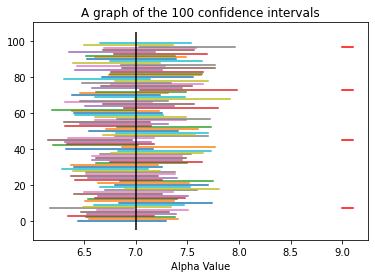

In [15]:
from scipy.stats import chi2


# Returns the inverse of the Chi Squared distribution's CDF.
def inverse_chi_squared(free_deg, val):
    return chi2.ppf(val, free_deg)


# Calculates the sum of the logs that appear in the pivot equation above.
def pivot(smp_vals, xm):
    return 2*np.sum(np.log(smp_vals/xm) )


# Returns A value that is at the right of the confidence interval with a certain significance 
# when the left value of the significance interval is 0.
def conf_intrvl(smp_vals, xm, sig):
    return (inverse_chi_squared(len(smp_vals)*2, sig))/(pivot(smp_vals, xm))


# Minimizes the above function ($F^{-1}(sig+x) - F^{-1}(x)$) for a certain initial significance (calculates length of interval for many values, and takes the one that gives the minimizer).
def best_chi(free_deg, sig, num_to_check):

    x_vals = np.linspace(0, 1 - sig, num_to_check)
    interval_lengths = [inverse_chi_squared(free_deg, val + sig) - inverse_chi_squared(free_deg,val) for val in x_vals]

    return x_vals[np.argmin(interval_lengths)]


# Uses the best_chi function to calculate the minimal length confidence interval (using our pivot) for num_of_iter number of samples.
def do_optim_intrvls(xm, alpha, sig, smp_size, num_of_iter):

	val = best_chi(smp_size, sig, 10**4)
	list_of_intervals = []

	for i in range(num_of_iter):
		smp_vals = (np.random.pareto(alpha, smp_size)+ 1) * xm
		list_of_intervals.append((conf_intrvl(smp_vals, xm, val), conf_intrvl(smp_vals, xm, val + sig)))

	return list_of_intervals


# Plots an interval between 2 x-values, with the y-value being y_val
def plot_interval(lower, upper, y_val):
    plt.plot(np.linspace(lower, upper, 10**3), [y_val for i in range(10**3)])
    return 


# Creates the intervals for the visualiztion, num_of_errors will denote how many intervals do not containt alpha. 
num_of_intrvls = 100
intervals = do_optim_intrvls(xm, alpha, 0.95, 10**3, num_of_intrvls)
num_of_errors = 0

# Plots each confidence interval on evenly spaced y-values, and if alpha is not in the interval it plots a red mark next to the interval
for idx, intrvl in enumerate(intervals):

    plot_interval(intrvl[0], intrvl[1], idx)
    
    if (intrvl[0] > alpha) or (alpha > intrvl[1]):
        num_of_errors += 1
        plt.plot(np.linspace(9, 9.1, 10**2), [idx for j in range(10**2)], color='red')


# Prints the number of errors.
print(f"The number of intervals that do not contain the real value of alpha is: {num_of_errors}")

# Adds a vertical line at alpha that helps us get a frame of reference for each interval. 
# We the execute the plot.
plt.vlines(alpha, -5, 105, colors="black")
plt.xlabel("Alpha Value")
plt.title("A graph of the 100 confidence intervals")
plt.show()

To see a comparison of how these intervals look like for $N=10^3$ or $N=10^5$ and to see the metrics associated that we have discussed above we use the following code: 

The average length of pivot based intervals with 10^3 samples is: 0.8637815545365126
The standard deviation of the length of pivot based intervals with 10^3 samples is: 0.026497471294383977
The level of symmetry of the pivot based intervals with 10^3 samples is: 0.18561395445392215

The average length of pivot based intervals with 10^5 samples is: 0.08676681817090641
The standard deviation of the length of pivot based intervals with 10^5 samples is: 0.00025041153975914073
The level of symmetry of the pivot based intervals with 10^5 samples is: 0.015727800251698013


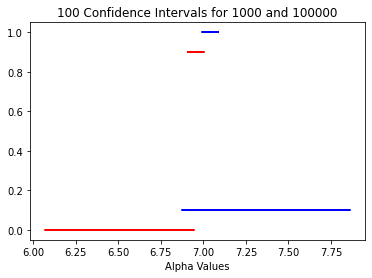

In [16]:
# This calculates 100 confidence intervals using 1000 samples, The y_values are used just to separate the values in the plot.
intervals =  do_optim_intrvls(xm, alpha, 0.95, 10**3, num_of_intrvls)
print(f"The average length of pivot based intervals with 10^3 samples is: {average_length_of_intervals(intervals)}")
print(f"The standard deviation of the length of pivot based intervals with 10^3 samples is: {standard_deviation_of_length_of_intervals(intervals)}")
print(f"The level of symmetry of the pivot based intervals with 10^3 samples is: {how_asymmetric(intervals, alpha)}\n")


left_side, right_side = [intervals[i][0] for i in range(num_of_intrvls)], [intervals[i][1] for i in range(num_of_intrvls)] 
y_vals_1 = [0 for i in range(num_of_intrvls)]
y_vals_2 = [0.1 for i in range(num_of_intrvls)]

# This calculates 100 confidence intervals using 1000 samples, The y_values are used just to separate the values in the plot.
intervals_for_hundred_thousand = do_optim_intrvls(xm, alpha, 0.95, 10**5, num_of_intrvls)
print(f"The average length of pivot based intervals with 10^5 samples is: {average_length_of_intervals(intervals_for_hundred_thousand)}")
print(f"The standard deviation of the length of pivot based intervals with 10^5 samples is: {standard_deviation_of_length_of_intervals(intervals_for_hundred_thousand)}")
print(f"The level of symmetry of the pivot based intervals with 10^5 samples is: {how_asymmetric(intervals_for_hundred_thousand, alpha)}")


left_side_2, right_side_2 = [intervals_for_hundred_thousand[i][0] for i in range(num_of_intrvls)], [intervals_for_hundred_thousand[i][1] for i in range(num_of_intrvls)]
y_vals_3 = [0.9 for i in range(num_of_intrvls)]
y_vals_4 = [1 for i in range(num_of_intrvls)]

# Plotting The above values.
plt.title("100 Confidence Intervals for 1000 and 100000")
plt.xlabel("Alpha Values")
plt.plot(left_side, y_vals_1, color="red")
plt.plot(right_side, y_vals_2, color="blue")
plt.plot(left_side_2, y_vals_3, color="red")
plt.plot(right_side_2, y_vals_4, color="blue")
plt.show()

Where the red dots are the left side of the confidence interval, and the blue ones are the right side (these are very dense as can be seen). By the metrics we know the variance is quite low And so these intervals can be virtually created by taking a red dot and adding the correct length (which like we said doesn't change much). (This of course is done post-hoc.)

# 4.(5): Comparison Of Means Of Samplings For "Sensitive" $\alpha$ Values

As can be seen in the "law of large numbers", and as we saw during the course - the sample average is usually a good estimate for the expected value. Meaning that 

$$\text{For i.i.d. random variables }\{X_i\}_{i=1}^n \text{ we can take }\bar{X}:=\frac{1}{n}\sum_{i=1}^n X_i\text{ as an estimator for }\mathbb{E}[X_i]$$

Why is this true? first it is an unbiased estimator - 

$$\mathbb{E}\left[\bar{X}\right] = \mathbb{E}\left[\frac{1}{n}\sum_{i=1}^n X_i\right] =\frac{1}{n} \sum_{i=1}^n \mathbb{E}[X_i] = \frac{1}{n}\cdot n\cdot\mathbb{E}[X_i] = \mathbb{E}[X_i]$$

Additionally if $\text{Var}(X_i) = \sigma^2$, then the variance of the estimator is 
$$\text{var}\left(\bar{X}\right) = \text{Var}\left(\frac{1}{n}\sum_{i=1}^n X_i\right) =\frac{1}{n^2} \sum_{i=1}^n \text{Var}(X_i) = \frac{1}{n^2}\cdot n\cdot\sigma^2 = \frac{\sigma^2}{n}$$

Meaning that when $n\rightarrow\infty$ this variance should go to zero and so this would be a good estimator for the expected value. And so we will try to see how this works for our case. We will sample the sizes that appear in the question and average out for each of these samples. Then we will plot these averages out to get an indication for the estimate. We will also be able to see how the averages turn out for each values as a function of the size of sample. And finally we will also be able to see the comparison between $\alpha=0.9$ and $\alpha=1.1$. 
In order to do that we will employ the following function -

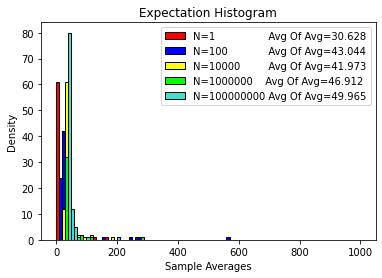

In [17]:
from matplotlib.patches import Rectangle

 
# Samples the pareto distribution 100 times of a certain shape, and return their averages.
def hundred_times_average(xm, alpha, smp_size):

    averages = []

    for i in range(100):
        s = (np.random.pareto(alpha, smp_size) + 1) * xm
        averages.append(np.mean(s))

    return averages


alpha = 1.1
smp_sizes = [10**(2*i) for i in range(5)]

# List of the means we get from the hundred_times_average for the different sample sizes we are interested in.
list_of_lists = [hundred_times_average(xm, alpha,i) for i in smp_sizes]

# Averages out (up to 3 digits after the dot) the lists in lists of lists
average_of_averages = [int(np.mean(lister)*10**3)/(10.0**3) for lister in list_of_lists]

plt.xlabel('Sample Averages')
plt.ylabel('Density')
plt.title('Expectation Histogram')

# Creates the "map" in the plot
handles = [Rectangle((0, 0), 1, 1, color=c, ec="k") for c in ['red', 'blue',
'yellow', 'lime', 'turquoise']] 
labels = ['N=1                 Avg Of Avg=' + str(average_of_averages[0]), 'N=100             Avg Of Avg=' + str(average_of_averages[1]),'N=10000         Avg Of Avg=' + str(average_of_averages[2]),
            'N=1000000    Avg Of Avg=' + str(average_of_averages[3]), 'N=100000000 Avg Of Avg=' + str(average_of_averages[4])]            
plt.legend(handles, labels)


# Plots the values from list_of_lists 
plt.hist(list_of_lists[0], color='red', bins=100, edgecolor='black',
range=[0, 1000])

plt.hist(list_of_lists[1], color='blue', bins=100, edgecolor='black', 
range=[0, 1000])

plt.hist(list_of_lists[2], color='yellow', bins=100, edgecolor='black',
range=[0, 1000]) 

plt.hist(list_of_lists[3], color='lime', bins=100, edgecolor='black',
range=[0, 1000])

plt.hist(list_of_lists[4], color='turquoise', bins=100, edgecolor='black',
range=[0, 1000])

plt.show()

(Of course we can change the value of $\alpha$ to be as pleased, this doesn't change the code in any significant way.)

## Explanation Of Differeng Results For Different $\alpha$'s

First of all as can be seen - the averages of the averages are very very different between these values, even though the $\alpha$'s are quite close together. And so an explanation is needed in order to understand this difference. Additionally we can see that the averages of the averages for $\alpha=0.9$ can be very large and change a lot as a function of the number of samples. When looking though at this for $\alpha=1.1$, it seems to "not escape" too much and the values are more bounded. And more over The samples for $\alpha=1.1$ seems to be much less spread over then that of $\alpha=0.9$. That being said when it comes to $\alpha=1.1$, it still doesn't converge as fast as one would expect. Now we will try to explain these phenomena. 


This means we need to understand the variance and mean of these distributions, and how the different choices of $\alpha$ affects this result. 
Given $X\sim \text{Par}(x_m,\alpha)$ we have that

$$\mathbb{E}[ X ] = \int_{x_m}^\infty x\cdot \frac{\alpha x_m^{\alpha}}{x^{\alpha+1}} dx \approx O\left(\int_{x_m}^\infty t^{-\alpha}dt\right) \begin{cases}<\infty, & \alpha > 1\\ =\infty, & \text{Otherwise}\end{cases}$$

Meaning there is expected value when $\alpha>1$ and otherwise the expected value is infinite. Additionally

$$\text{Var}(X) = \mathbb{E}\left[ X^2\right] - \mathbb{E}[ X]^2$$

And so if the expected value is finite then the variance is finite if and only if the second moment is finite. (It is also known that if the second moment is finite so is the first, and so we will find when the second moment is finite - and this implies that when the second moment is finite we can just assume the the first one is finite too). And so

$$\mathbb{E}\left[ X^2\right] = \int_{x_m}^\infty x^2\cdot \frac{\alpha\cdot x_m^{\alpha}}{x^{\alpha+1}} dx = O\left(\int_{x_m}^\infty t^{-\alpha+1}dt\right) \begin{cases}<\infty ,& \alpha>2 \\ =\infty ,& \text{Otherwise}\end{cases} $$


And so the variance is finite if and only if $\alpha>2$. And so notice that for $\alpha=0.9$ both values are infinite, and for $\alpha=1.1$ only the mean is finite. This means that for $\alpha=0.9$ we can't expect any type of convergence for the sample average to the mean since it isn't finite. This explains why for $\alpha=0.9$ we get such anamolous results for that value, and why it spreads out a lot as N goes up. This also explains the situation for $\alpha=1.1$. There is very much obvious convergence of the sample average to the mean of the distribution. Additionally this convergence is relatively slow because the variance is infinite, and this is known to imply slower convergence in the law of large numbers.